In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from math import sqrt
from scipy.special import erfc

In [14]:
def getPrecise(t):
    res = np.zeros(N)
#     for i in range(N):
#         res[i] = T0*erfc(i/(2*sqrt(L*t+1e-10)))

    if t > 0:
        for i in range(N):
            res[i] = T0*erfc(i*dx/(2*sqrt(L*t*dt)))
        
    return res

# Линейное уравнение теплопроводности

$$
\frac{\partial{T}}{\partial{t}} = \lambda \frac{\partial^2{T}}{\partial{x^2}},  \lambda > 0
$$

In [47]:
L = 1 # lambda
T0 = 10

dt = 0.18
dx = 0.6

N = 50
T = 500

sigma = L*dt/dx**2
print("Число Куранта = ", sigma)

assert sigma <= 0.5, "Схема неустойчива!"

Число Куранта =  0.5


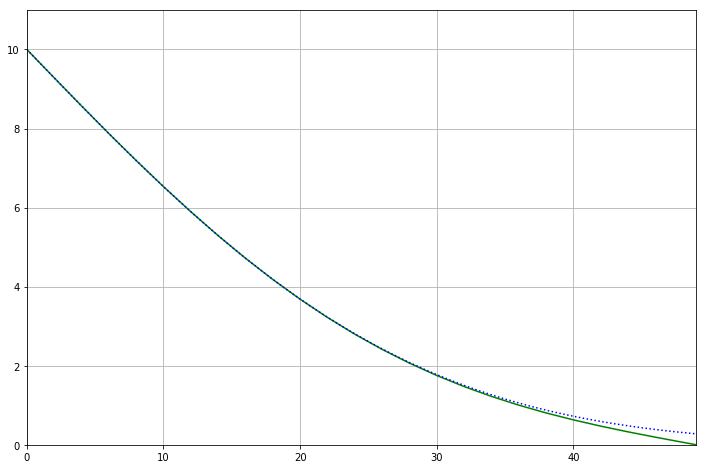

In [50]:
A = np.zeros((T,N))

for n in range(-1, T-1):
    A[n+1][0] = T0
    for i in range(1, N-1):
        A[n+1][i] = A[n][i] + sigma*(A[n][i+1]-2*A[n][i]+A[n][i-1])
    A[n+1][N-1] = 0    
        

fig, ax = plt.subplots(figsize = (12, 8))
xdata, ydata = range(N), []
ax.grid(True)
ln, = plt.plot([], [], color = 'g', linestyle = '-')
ln2, = plt.plot([], [], color = 'b', linestyle = ':')

frame_const = 3

def init():
    ax.set_xlim(0, N-1)
    ax.set_ylim(0, T0*1.1)
    return ln,

def update(t):
    ydata = A[frame_const*t]
    ln.set_data(xdata, ydata)
    ln2.set_data(xdata, getPrecise(frame_const*t))
    return ln,

anim = FuncAnimation(fig, update, frames=T//frame_const, init_func=init, interval=30, blit=True)
HTML(anim.to_html5_video())

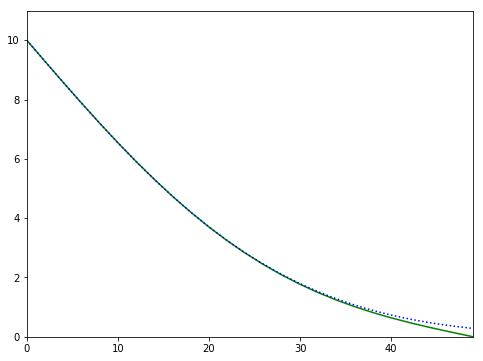

In [49]:
A = np.zeros((T,N))

for n in range(-1, T-1):
    A[n+1][0] = T0
    for i in range(1, N-1):
        A[n+1][i] = A[n][i] + sigma*(A[n][i+1]-2*A[n][i]+A[n][i-1])
    A[n+1][N-1] = 0    
        

fig, ax = plt.subplots(figsize = (8, 6))
xdata, ydata = range(N), []
ln, = plt.plot([], [], color = 'g', linestyle = '-')
ln2, = plt.plot([], [], color = 'b', linestyle = ':')

def init():
    ax.set_xlim(0, N-1)
    ax.set_ylim(0, T0*1.1)
    return ln,

def update(t):
    ydata = A[t]
    ln.set_data(xdata, ydata)
    ln2.set_data(xdata, getPrecise(t))
    return ln,

anim = FuncAnimation(fig, update, frames=T, init_func=init, interval=20, blit=True)
HTML(anim.to_html5_video())